Author : Myriam Bontonou

In this notebook, you will:
* **prepare the IBC dataset** following the classical few-shot benchmarking rules,
* discover the organization of the data (description, images, images_meta, collections_meta),
* **discover the contents of the dataset** (statistical maps associated with conditions, contrasts).

In [1]:
import os
import numpy as np
from numpy import savez_compressed
# from matplotlib import pyplot
# import random as rd
from tqdm import tqdm
import pandas as pd
from itertools import compress
import nibabel as nib
import nilearn
from nilearn.datasets import fetch_icbm152_brain_gm_mask  # load_mni152_brain_mask
from nilearn.input_data import NiftiLabelsMasker #, NiftiMasker
from nilearn.image import load_img
from nilearn.plotting import view_img #, plot_stat_map, plot_roi
from nilearn.regions import signals_to_img_labels
import torch

# from loader import *
# import torch.utils.data.sampler as spler

In [2]:
### TO UPDATE.
# Path towards the folder where data from the command nilearn.datasets.fetch_neurovault_ids(collection_ids=[6618]) are stored.
nilearn_data_path = '/home/brain/nilearn_data/neurovault/collection_6618/'
# Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
path_Glasser = '/home/brain/Myriam/fMRI_transfer/github/dataset/Glasser_masker.nii.gz'

# 1. Select the data of interest for our study.

We are interesting in learning to classify fMRI statistical maps according to the conditions they represent. Each class is a condition. Each example is a statistic map. So we need to:
- Select the maps associated to conditions.

To discover more the dataset, we can:
- Count the number of conditions.
- Count the number of images associated to a condition.

In [3]:
# Download IBC dataset on NeuroVault.
data = nilearn.datasets.fetch_neurovault_ids(collection_ids=[6618])

Reading local neurovault data.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
Already fetched 5 images
Already fetched 6 images
Already fetched 7 images
Already fetched 8 images
Already fetched 9 images
Already fetched 10 images
Already fetched 11 images
Already fetched 12 images
Already fetched 13 images
Already fetched 14 images
Already fetched 15 images
Already fetched 16 images
Already fetched 17 images
Already fetched 18 images
Already fetched 19 images
Already fetched 20 images
Already fetched 21 images
Already fetched 22 images
Already fetched 23 images
Already fetched 24 images
Already fetched 25 images
Already fetched 26 images
Already fetched 27 images
Already fetched 28 images
Already fetched 29 images
Already fetched 30 images
Already fetched 31 images
Already fetched 32 images
Already fetched 33 images
Already fetched 34 images
Already fetched 35 images
Already fetched 36 images
Already fetched 37 images
Already fetched 3

In [4]:
# Store the list of classes.
# What we call a class is a condition measured during an experiment.
# Thus, among all contrasts associated with images in the dataset, we only keep the ones associated with a condition, and not with a contrast
# between two conditions.
# We also remove the conditions associated with the experiment 'bang', as it has not enough images.

classes = []
for image in data.images_meta:
    # Retrieve the contrast/condition name.
    contrast_definition = image['contrast_definition']
    # We remove the experiment 'bang' because only 11 maps have been computed.
    if contrast_definition != 'non-speech section in movie watching':
        if contrast_definition != 'speech sections in movie watching': 
            # If it contains the word 'vs' (or a variant), we assume the statistic_map is a contrast.
            # If not, we assume it is a condition.
            contrast_definition = contrast_definition.split(' ')
            if 'vs' not in contrast_definition:
                if 'vs.' not in contrast_definition:
                    if 'versus' not in contrast_definition:     
                        if image['contrast_definition'] not in classes:
                            classes.append(image['contrast_definition'])

print("There are", len(classes), "classes.")  

There are 93 classes.


In [5]:
# Number of examples per class.
examples = {}
[examples.setdefault(c, 0) for c in classes]

for image in data.images_meta:
    # Retrieve the contrast/condition name.
    contrast_definition = image['contrast_definition']
    # If the statistic_map is a condition and not a ffx map, we add it as an example in examples dict.
    if contrast_definition in classes:
        name = image['name'].split('_')
        if 'ffx' not in name:
            examples[contrast_definition] += 1

print('min:', min(examples.values()), '\nQ1:', np.percentile(list(examples.values()), 25, interpolation = 'midpoint'), '\nmedian:', np.median(list(examples.values())), '\nQ3:', np.percentile(list(examples.values()), 75, interpolation = 'midpoint') , '\nmax:', max(examples.values()))
print("The total number of data samples in our study is", np.sum(list(examples.values())), '.')

min: 21 
Q1: 26.0 
median: 33.0 
Q3: 44.0 
max: 78
The total number of data samples in our study is 3245 .


In [6]:
# Number of examples per class and per task.

# Retrieve the names of the tasks.
tasks = []
for image in data.images_meta:
    if image['task'] not in tasks:
        tasks.append(image['task'])

# Retrieve to which task a condition is associated with.
contrasts = {}
[contrasts.setdefault(task, []) for task in tasks]

for image in data.images_meta:
    if image['contrast_definition'] not in contrasts[image['task']]:
        contrasts[image['task']].append(image['contrast_definition'])

examples_per_task = {}
[examples_per_task.setdefault(task, []) for task in tasks]
actual_tasks = []
for condition in examples.keys():
    # Retrieve the task associated to the condition
    for key in contrasts.keys():
        if condition in contrasts[key]:
            task = key
            if task not in actual_tasks:
                actual_tasks.append(task)
            break
    examples_per_task[task].append({condition: examples[condition]})

# For instance:
TASK = 'archi_social'
examples_per_task[TASK]

[{'Reading a mechanistic story': 36},
 {'Listen to natural sound': 36},
 {'Mental motion of triangle': 36},
 {'Listening to a mechanistic tale': 36},
 {'False-belief tale': 36},
 {'False-belief story': 36},
 {'Listen to voice sound': 36},
 {'Randomly drifting triangle': 36}]

# 2. Create a dataloader.

## a. Data of interest
First, we need to store in a class the paths/meta of the images associated with the studied conditions.

In [7]:
def find(tasks:list,task_set:list):
    bin_tasks = []
    for t in tasks:
        if t in task_set:
            bin_tasks.append(True)
        else:
            bin_tasks.append(False)        
    return bin_tasks

class IBC():
    # This class aims to search images of subject(s) / task(s) / contrast(s) (or condition(s)).
    
    def __init__(self, ibc_data):
        # Get the lists of subject names, tasks, contrasts (and conditions) and images.
        # ibc_data : dictionnary obtained by using nilearn fetcher.
        
        self.subjectnames = [image['subject_id'] for image in ibc_data.images_meta]
        self.tasks = [image['task'] for image in ibc_data.images_meta]
        self.contrasts = [image['contrast_definition'] for image in ibc_data.images_meta]
        self.images = ibc_data.images
        self.meta = ibc_data.images_meta
        self.ffx = ['ffx' not in image['name'].split('_') for image in ibc_data.images_meta]

    def __getsourcetarget__(self, task_set:list, subject_set:list, contrast_set:list, remove_ffx=True):
        # 1) Select the images whose task is in task_set.
        # 2) Select the images whose subject is in subject_set.
        # 3) Select the images whose contrast in in contrast_set.
        # 4) We only select the ap/pa statistic_map (we do not consider the Fixed Effects maps).
        
        # Select the images associated to tasks.
        bin_tasks = find(self.tasks, task_set)
        subjectnames = list(compress(self.subjectnames, bin_tasks))
        tasks = list(compress(self.tasks, bin_tasks))
        contrasts = list(compress(self.contrasts, bin_tasks))
        images = list(compress(self.images, bin_tasks))
        meta = list(compress(self.meta, bin_tasks))
        ffx = list(compress(self.ffx, bin_tasks))

        # Select the images associated subjects.
        bin_subjectnames = find(subjectnames, subject_set)
        subjectnames = list(compress(subjectnames, bin_subjectnames))
        tasks = list(compress(tasks, bin_subjectnames))
        contrasts = list(compress(contrasts, bin_subjectnames))
        images = list(compress(images, bin_subjectnames))
        meta = list(compress(meta, bin_subjectnames))
        ffx = list(compress(ffx, bin_subjectnames))

        # Select the images associated to contrasts.
        bin_contrasts = find(contrasts, contrast_set)
        subjectnames = list(compress(subjectnames, bin_contrasts))
        tasks = list(compress(tasks, bin_contrasts))
        contrasts = list(compress(contrasts, bin_contrasts))
        images = list(compress(images, bin_contrasts))
        meta = list(compress(meta, bin_contrasts))
        ffx = list(compress(ffx, bin_contrasts))
        
        # Keep the ap/pa statistic_map only.
        if remove_ffx:
            subjectnames = list(compress(subjectnames, ffx))
            tasks = list(compress(tasks, ffx))
            contrasts = list(compress(contrasts, ffx))
            images = list(compress(images, ffx))
            meta = list(compress(meta, ffx))

        return images, contrasts, tasks, subjectnames, meta

dataset = IBC(data)

In [8]:
# images contains the paths to all nii images associated to a ap/pa stastitic map (not ffx) and to a condition (not a contrast).
images, labels, tasks, subjectnames, meta = dataset.__getsourcetarget__(np.unique(dataset.tasks), np.unique(dataset.subjectnames), classes)

## b. Parcellation
In this work, we parcel the images into 360 regions before using them.

In [9]:
# MNI 152 is a 3D coordinate system for localization in the brain. It is an average taken from 152 healthy individuals.
# ICBM452 -> ICBM152 -> MNI152 -> MNI305 -> Talairach -> Brodmann.
# Current standard MNI template: ICBM152. It is an average of 152 normal MRI scans that have been matched to the MNI305.
mask_mni = fetch_icbm152_brain_gm_mask()

# Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
glassermasker = NiftiLabelsMasker(labels_img=path_Glasser,mask_img=mask_mni)
glassermasker.fit()

for curmeta in tqdm(meta):
    # Location of the MRI scan on NeuroVault.
    current_url = curmeta['file']
    # Name attributed to the image locally.
    current_newname = os.path.split(curmeta['relative_path'])[1]
    filepath = os.path.join(nilearn_data_path, current_newname)
    
    # Some images were missing. So we manually downloaded them.
    if os.path.exists(filepath):
        #print("File {} already exists".format(filepath))
        pass
    else:
        #print("Downloading file {}...".format(filepath))
        os.wget.download(url=current_url,out = filepath)
    
    # Attribute to each image nii a parcellated version stored in a npz file.
    npzfile = os.path.splitext(os.path.splitext(filepath)[0])[0]+'.npz'
    
    if os.path.exists(npzfile):
        #print("Parcellated file {} already exists".format(npzfile))
        pass
    else:       
        #print("Parcellating...")
        X = glassermasker.fit_transform([filepath])
    
        ## Save the npz file
        savez_compressed(npzfile,X=X)

100%|██████████| 3245/3245 [00:00<00:00, 95173.78it/s]


## c. Visualization


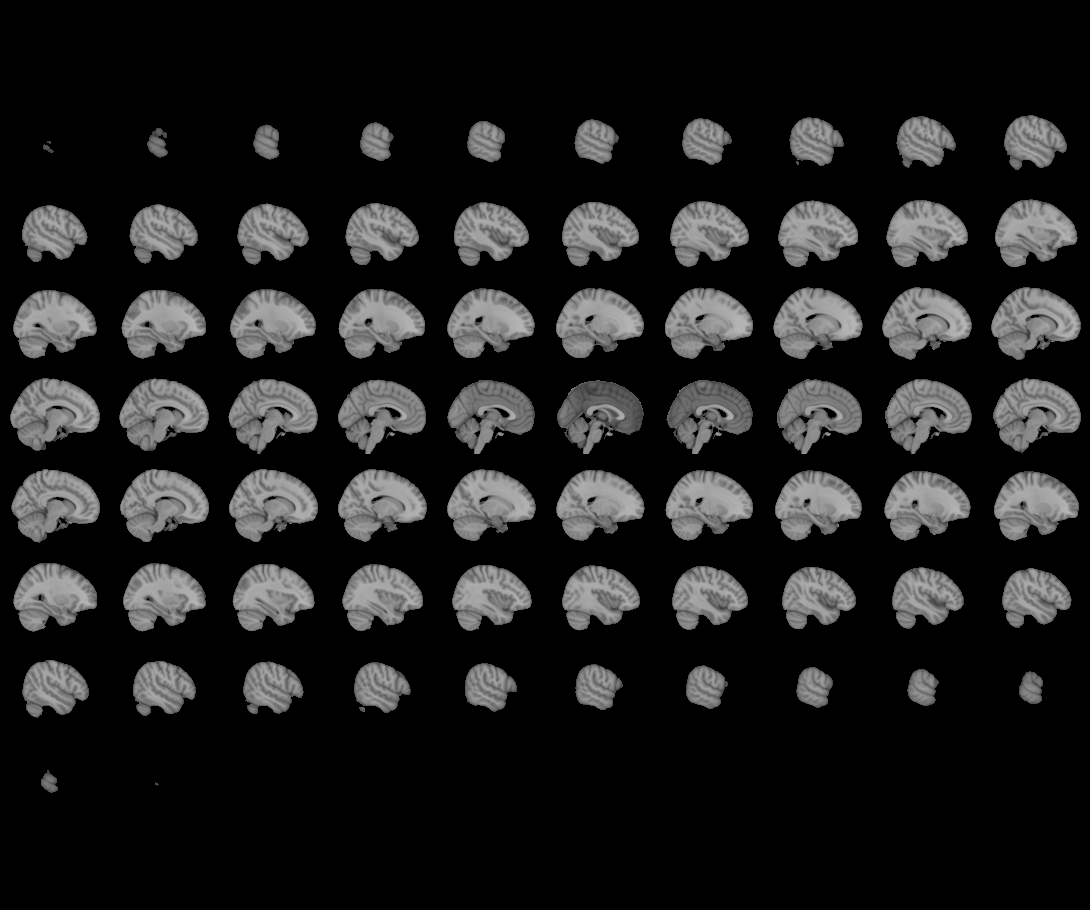
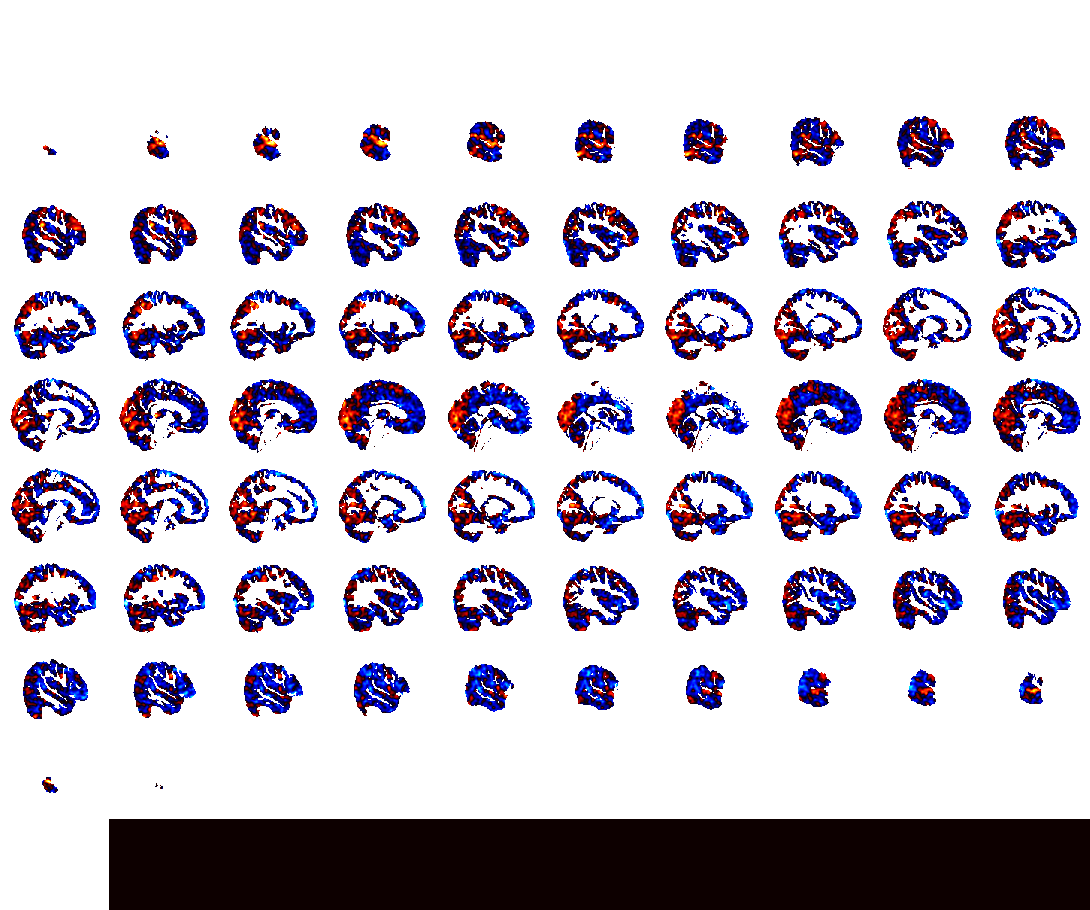

In [10]:
# Visualization of the nii image.
niifile = images[0]
condition = meta[0]['contrast_definition']

view = view_img(niifile,title=condition)
view

The whole fMRI scan is reduced to a signal spanning over 360 regions.



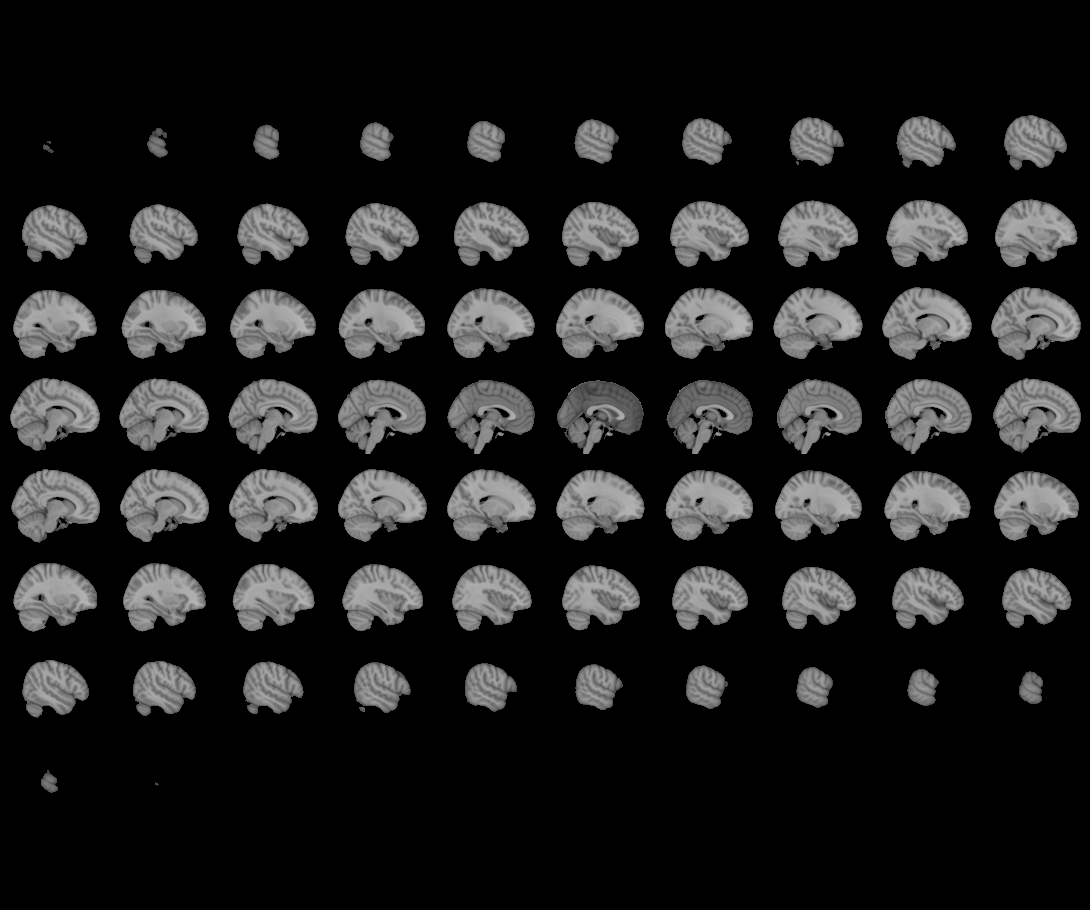
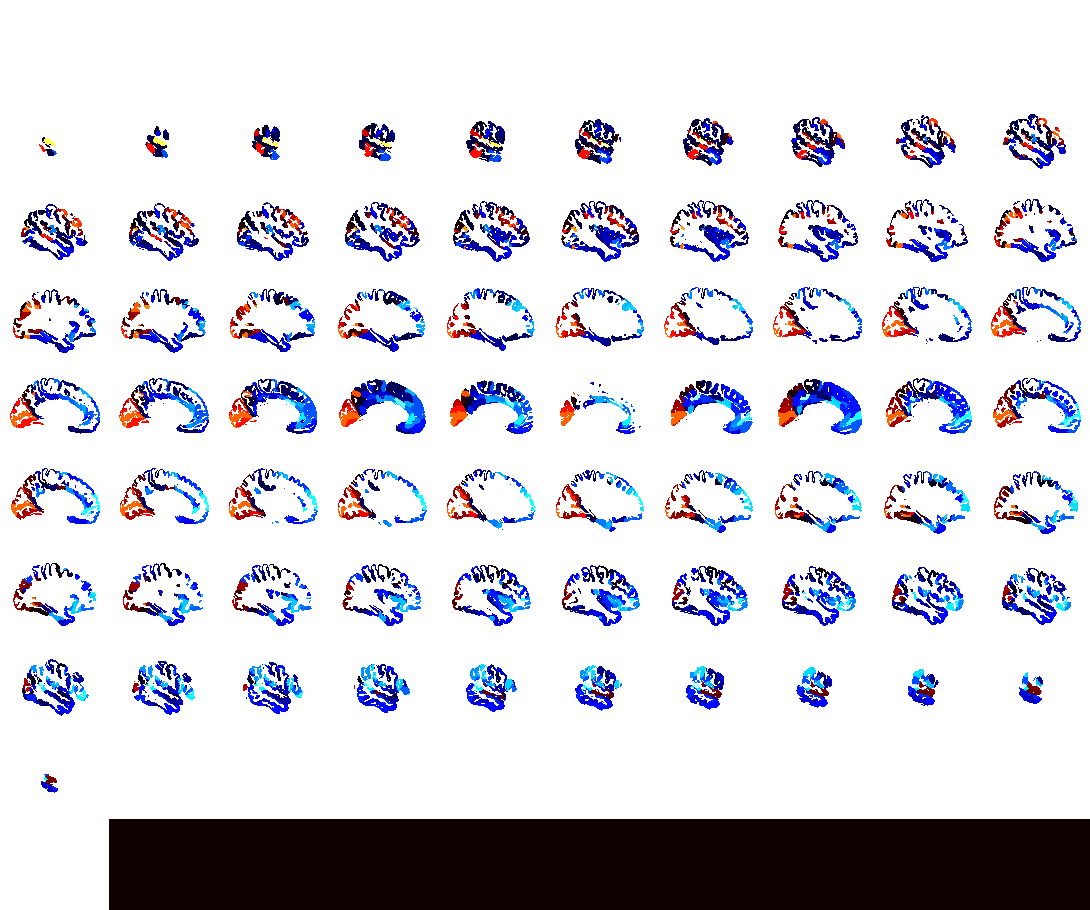

In [11]:
# Visualization of the parcellated image.
npzfile = os.path.splitext(os.path.splitext(niifile)[0])[0]+'.npz'
X = np.load(npzfile)['X']
print("The whole fMRI scan is reduced to a signal spanning over", X.shape[1], "regions.")
img = signals_to_img_labels(X,path_Glasser,mask_img=mask_mni)
view = view_img(img,title=condition)
view


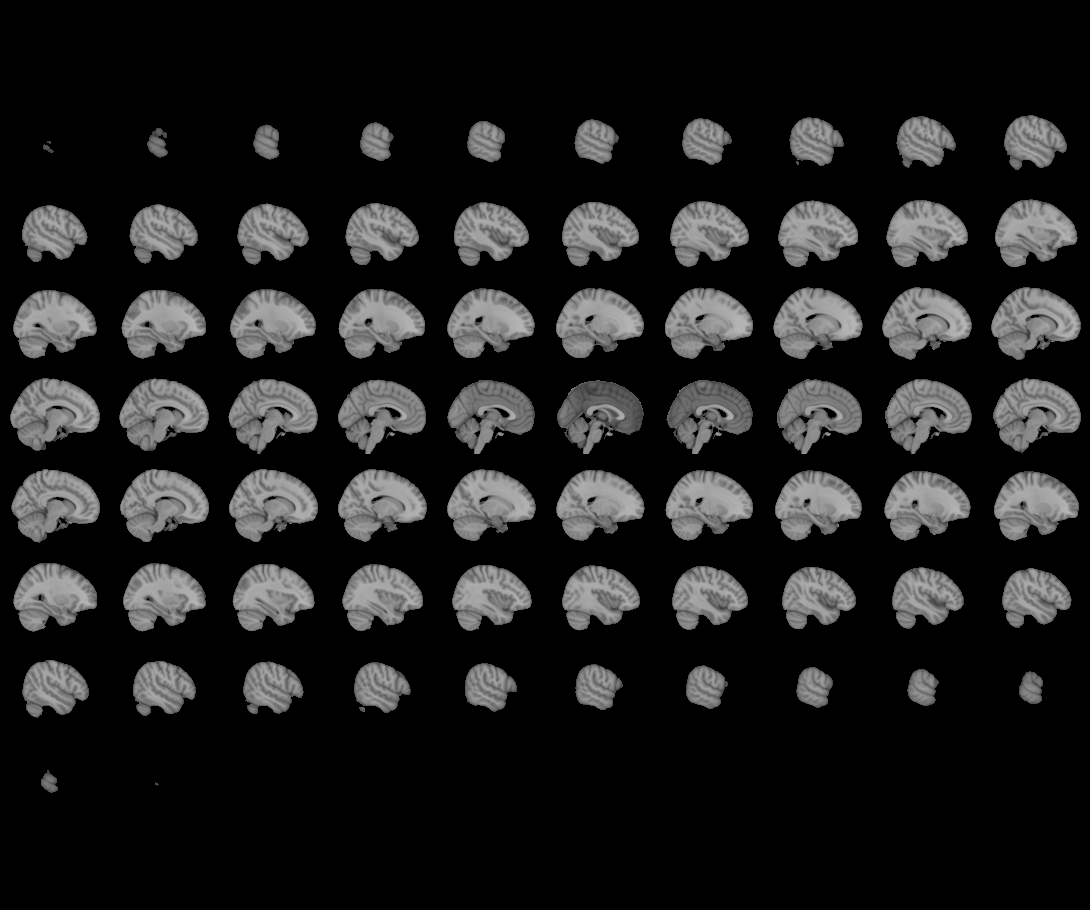
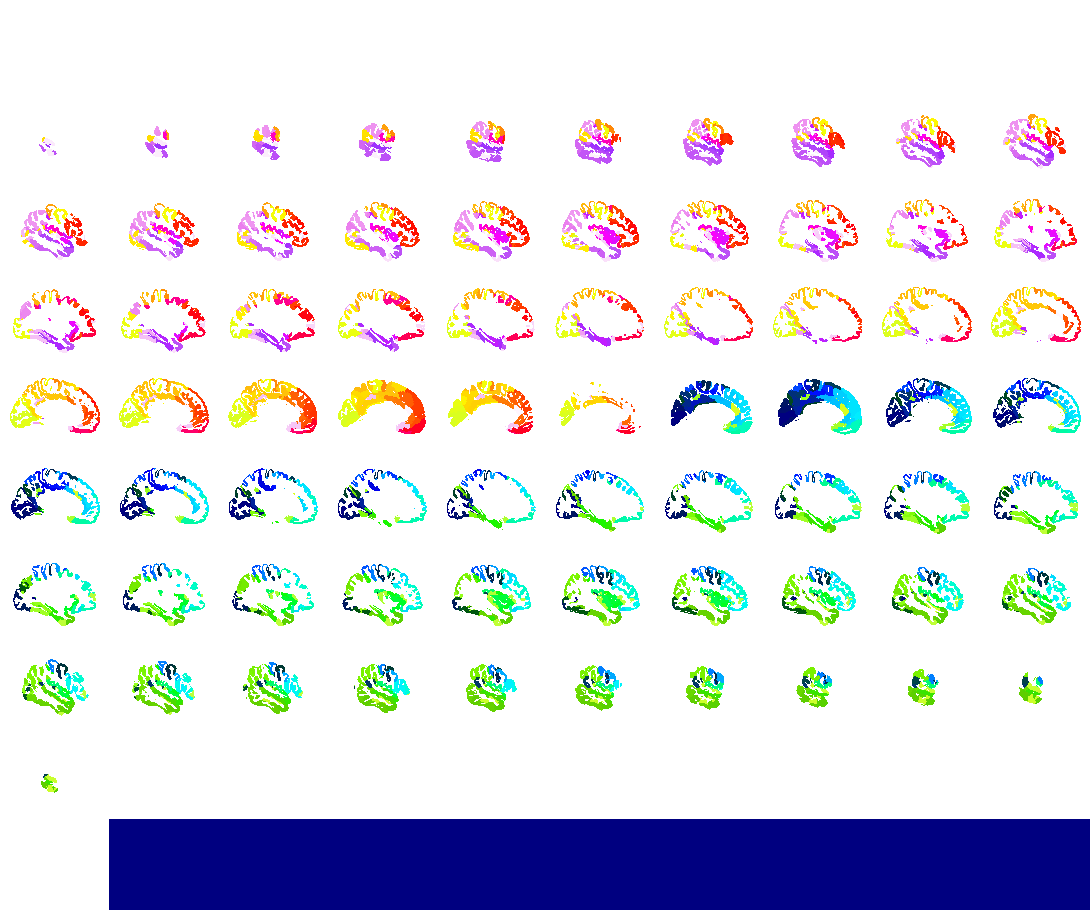

In [12]:
# Visualizing the ROI in a brain.

# Glasser contains 360 regions but their labels are floatting values between 0 and 54000.
# To better visualize the ROI, we can reindex the regions' labels. 

# First, we retrieve the data.
roi = load_img(path_Glasser)
data = roi.get_data()

# Then, we create a copy of the data in which, 
# we replace each label by its index in the sorted array of all labels.
indexes = np.unique(roi.get_data())

new_data = np.zeros(data.shape)
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        for z in range(data.shape[2]):
            value = data[x, y, z]
            index = np.where(indexes==value)[0]
            new_data[x, y, z] = index

# Finally, we save the reindexed version of Glasser and we plot it.
reindexed_roi = nib.Nifti1Image(new_data, roi.affine, roi.header)
nib.save(reindexed_roi, 'reindexed_roi.nii')
atlas = view_img('reindexed_roi.nii', vmax=360, symmetric_cmap=False, threshold=0.001, cmap='gist_ncar')
atlas

## d. Splitting the dataset into three datasets: base / validation / novel.

We want to define a dataset suitable for evaluating few-shot learning on fMRI-related data. More precisely, we want to see if we are able to classify conditions represented on statistical maps when few maps are available for training. On standard images, people try knowledge-transfer strategies. To that end, they split their data into three sets: base / validation / novel. The first two are used to extract general knowledge. The last one to mimic studies with few examples. We have decided to follow the same strategy. To that end, we arbitrarily attributed experiments (and so all the associated conditions) between the datasets.

In [13]:
# Random classes.
all_tasks = np.unique(tasks)

In [14]:
split = np.random.choice(all_tasks, replace=False, size=len(all_tasks))

In [15]:
train_tasks = split[:13]
val_tasks = split[13:15]
test_tasks = split[15:]

In [16]:
# In three csv files (corresponding to the three splits), we store the path of the images and their labels.
train_data = []
val_data = []
test_data = []
train_classes = []
val_classes = []
test_classes = []

for i, task in enumerate(tasks):
    filename = images[i].split('/')[-1].split('.')[0]
    label = labels[i]
    infos = meta[i]
    
    if task in train_tasks:
        train_data.append((filename, label, task, infos))
        if label not in train_classes:
            train_classes.append(label)
    elif task in val_tasks:
        val_data.append((filename, label, task, infos))
        if label not in val_classes:
            val_classes.append(label)
    elif task in test_tasks:
        test_data.append((filename, label, task, infos))
        if label not in test_classes:
            test_classes.append(label)
    else:
        if task != 'bang':
            raise NameError(task)

In [17]:
len(train_data)

2176

In [18]:
len(val_data)

297

In [19]:
len(test_data)

772

In [20]:
len(train_classes)

59

In [21]:
len(val_classes)

10

In [22]:
len(test_classes)

24

In [23]:
# Save the splits in a folder.
def save_pd_to_csv(file, name):
    df = pd.DataFrame(file, columns = ['Filename', 'Label', 'Task', 'Meta'])
    df.to_csv(path_or_buf=f'split/{name}.csv', index=False)

save_pd_to_csv(train_data, 'train')
save_pd_to_csv(val_data, 'val')
save_pd_to_csv(test_data, 'test')